In [155]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import pandas as pd
import xgboost as xgb
import sklearn
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Data analysis part

In [147]:
datas = []
entries = pathlib.Path('data/')
summation = 0

for entry in entries.iterdir():
    df = pd.read_csv(entry, header=None)
    df = df.dropna(axis=0)
    if type(df.iloc[0,0]) == type('str'):
        df = df.iloc[1:]
    datas.append(df)

df_concat = pd.concat(datas)
df_concat.to_csv('all_datas.csv')

In [148]:
df = pd.read_csv('data/Output-S2-1.csv', header=None)
df = df.dropna(axis=0)

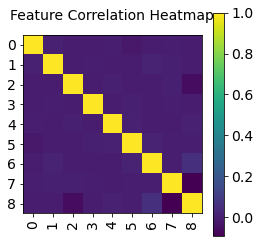

In [149]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)

In [168]:
# All datas from the first data set:
# x0 data:
x0 = df.iloc[:10000, 0].values
a = 0.2
b = 0.99
mean0 = (a + b)/2
std0 = (b - a)**2/12

#x1 data: 
x1 = df.iloc[:10000, 1].values
a = 0.2
b = 0.99
mean1 = (a + b)/2
std1 = (b - a)**2/12

#x2 data:
x2 = df.iloc[:10000, 2].values
a = -0.2
b = 1
mean2 = (a + b)/2
std2 = (b - a)**2/12

#x3 data:
x3 = df.iloc[:10000, 3].values
a = 0.01
b = 1
mean3 = (a + b)/2
std3 = (b - a)**2/12

#x4-x5 data:
x4 = df.iloc[:10000, 4].values
x5 = df.iloc[:10000, 5].values
a = 0.8
b = 4
mean45 = (a + b)/2
std45 = (b - a)**2/12

#x6 data:
x6 = df.iloc[:10000, 6].values
a = -0.2
b = 1
mean6 = (a + b)/2
std6 = (b - a)**2/12

#x7 data:
x7 = df.iloc[:10000, 7].values
a = 0.01
b = 1
mean7 = (a + b)/2
std7 = (b - a)**2/12

#y data:
y = df.iloc[:10000, 8].values

#All features and colors used for the plots
features = [x0, x1, x2, x3, x4, x5, x6, x7]
colors = ['tab:blue', 'tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink', 'tab:gray']

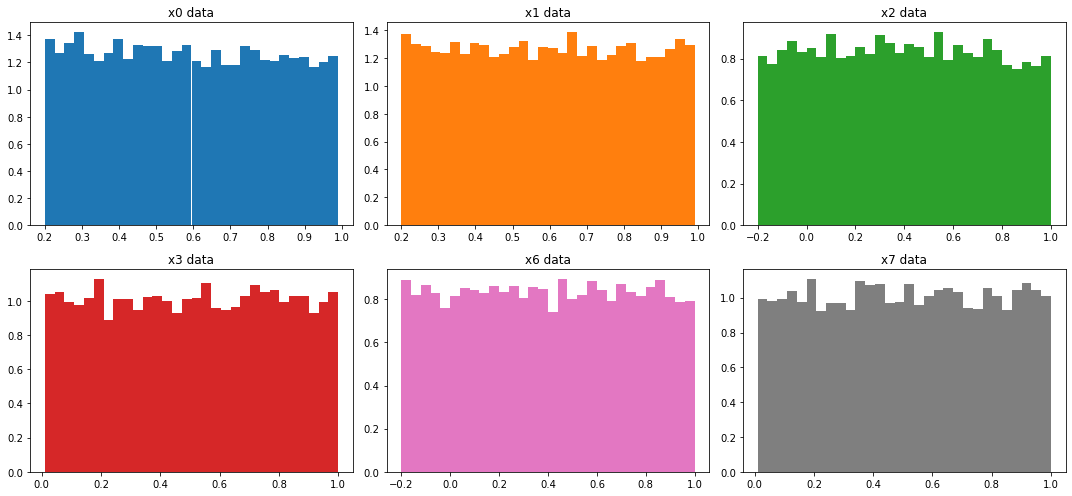

In [174]:
n_bins = 30
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 7))
indices = [0, 1, 2, 3, 6, 7]

for ax, i in zip(axes.flat, indices):
    ax.hist(features[i], n_bins, color=colors[i], density=1)
    ax.set_title('x%s data' %i)

fig.tight_layout()
plt.show()

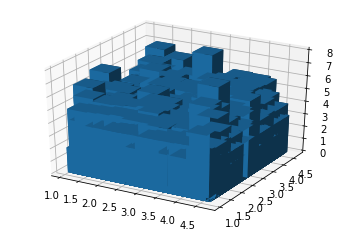

mean = 2.4 || std = 0.8533333333333335


In [152]:
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
hist, xedges, yedges = np.histogram2d(x4, x5, bins=75, range=[[0.8, 4], [0.8, 4]])

xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0
t
# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')
plt.show()
print('mean =',mean45,'||','std =', std45)

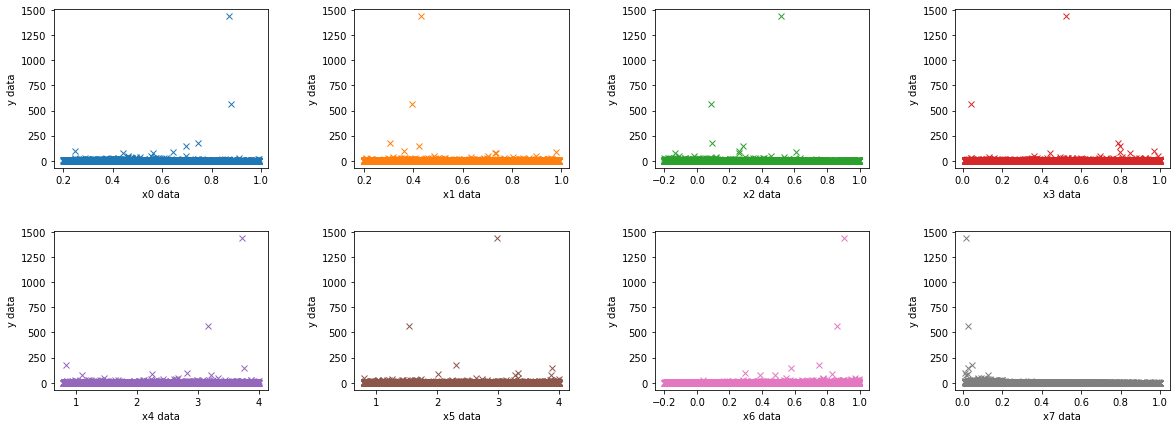

In [166]:
# All plots for xs against y with outliers:
fig, axs = plt.subplots(2, 4, figsize=(20,7))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for ax, i in zip(axs.flat, range(8)):
    ax.plot(features[i], y, 'x', color=colors[i])
    ax.set(xlabel='x%s data' %i, ylabel='y data')


# Neural Network part

In [180]:
train_ratio = 0.80
i = int(df.shape[0] * train_ratio)
train_set =  df[0:i]
test_set  =  df[i:] 
train_ratio = 0.8
i = int(df.shape[0] * train_ratio)

train_set =  df[0:i-1]
test_set  =  df[i:] 


X_train = train_set.iloc[:,0:8].values
y_train = train_set.iloc[:,-1].values

X_test = test_set.iloc[:,0:8].values
y_test = test_set.iloc[:,-1].values

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(24998, 8)
(24998,)
(6250, 8)
(6250,)


In [188]:
# Definition of some hyperparameters taken from lab10
learning_rate = 1e-3
num_epochs = 10
batch_size = 1000

dataset_train_tensor = torch.utils.data.TensorDataset(torch.from_numpy(X_train).unsqueeze(1).float(), torch.from_numpy(y_train).float())
dataset_test_tensor= torch.utils.data.TensorDataset(torch.from_numpy(X_test).unsqueeze(1).float(), torch.from_numpy(y_test).float())

dataset_train = torch.utils.data.DataLoader(dataset_train_tensor, batch_size=batch_size)
dataset_test = torch.utils.data.DataLoader(dataset_test_tensor, batch_size=100)

In [189]:
def MSE(prediction, target):
    n = target.shape[0]
    pred = prediction.detach().numpy()
    tar = target.numpy()
    return 1/(2*n) * np.mean((pred-tar)**2)

In [196]:
# Taken from lab10
def train(model, criterion, dataset_train, dataset_test, optimizer, num_epochs):
    print("Starting training")
    for epoch in range(num_epochs):
        # Train an epoch
        model.train()
        for batch_x, batch_y in dataset_train:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Evaluate the network (forward pass)
            prediction = model(batch_x)
            loss = criterion(prediction, batch_y)

            # Compute the gradient
            optimizer.zero_grad()
            loss.backward()

            # Update the parameters of the model with a gradient step
            optimizer.step()

        # Test the quality on the test set
        model.eval()
        accuracies_test = []
        for batch_x, batch_y in dataset_test:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        # Evaluate the network (forward pass)
        prediction = model(batch_x)
        accuracies_test.append(MSE(prediction, batch_y))

        print("Epoch {} | Test MSE: {:.5f}".format(epoch, sum(accuracies_test).item()/len(accuracies_test)))

In [197]:
class OTCmodel(nn.Module):
    def __init__(self):
        super().__init__()
        # For the moment i just used the architecture of LeNet because i have no idea where to start :)
        self.conv1 = nn.Conv1d(1, 30, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(30, 60, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(120, 20)
        self.conv_drop = torch.nn.Dropout()
        self.fc2 = nn.Linear(20, 1)

    def forward(self, x):
        relu = nn.functional.relu
        max_pool1d = torch.nn.functional.max_pool1d

        x = relu(max_pool1d(self.conv1(x), 2))
        x = relu(max_pool1d(self.conv_drop(self.conv2(x)), 2))
        x = x.view(-1, 120)
        x = relu(self.fc1(x))
        x = self.fc2(x)
        return x  

In [198]:
# If a GPU is available use cuda else use cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_otc = OTCmodel().to(device)

# Defining the loss function and the optimizer the best to use is adam()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_otc.parameters(), lr=learning_rate)

# training
train(model_otc, criterion, dataset_train, dataset_test, optimizer, num_epochs)


Starting training
Epoch 0 | Test MSE: 0.02449
Epoch 1 | Test MSE: 0.02403
Epoch 2 | Test MSE: 0.02410
Epoch 3 | Test MSE: 0.02406
Epoch 4 | Test MSE: 0.02401
Epoch 5 | Test MSE: 0.02402
Epoch 6 | Test MSE: 0.02398
Epoch 7 | Test MSE: 0.02397
Epoch 8 | Test MSE: 0.02395
Epoch 9 | Test MSE: 0.02394


# Testing with XGboost

In [199]:
train_ratio = 0.80
i = int(df_concat.shape[0] * train_ratio)
train_set = df_concat[0:i]
test_set = df_concat[i:] 
print(train_set.shape)
print(test_set.shape)

(395736, 9)
(98935, 9)


In [200]:
x_train = train_set.iloc[:,0:8].values
y_train = train_set.iloc[:,-1].values
x_test = test_set.iloc[:,0:8].values
y_test = test_set.iloc[:,-1].values

xgbr = XGBRegressor(verbosity=0)
xgbr.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=0)

In [201]:
ypred_x = xgbr.predict(x_test)
mse_x = mean_squared_error(y_test, ypred_x)
print("MSE:",mse_x)

MSE: 36.93842340141455


# Test Lasso 

In [202]:
clf = linear_model.LassoCV()
clf.fit(X=x_train, y=y_train)

LassoCV()

In [203]:
pred = clf.predict(x_test).astype('float')

In [204]:
def MSE(prediction, target):
  n = target.shape[0]
  return 1/(2*n) * np.mean((prediction-target)**2)

In [205]:
MSE(pred, y_test.astype('float'))

0.0001655051723669542

# Test Random Forest

In [206]:
model_rf = RandomForestRegressor(n_estimators=959, random_state=42)
#model_rf = ensemble.GradientBoostingRegressor(n_estimators=500, max_depth=4, learning_rate=0.01, loss='ls')

model_rf.fit(X_train, y_train)
pred_train_rf= model_rf.predict(X_train)

print(mean_squared_error(y_train,pred_train_rf))

ValueError: Found input variables with inconsistent numbers of samples: [24998, 395736]